# HW6 - Character Classification
Anirudh Lath | CS6017 | July 24, 2022
In this assignment we'll tackle a slightly more complicated image classification problem than MNIST digit classification. We're going to classify characters that contain (gasp!) letters!

The dataset we'll play with is from University of California, Irvine (UCI) and contains a bunch of images of letters of various fonts. Some printed + scanned, some the values screen-capped from a computer. The images are 20x20 pixels, grayscale.

In [286]:
# Prepare the notebook
import torchvision
import torch
import os

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))]) #convert from images to tensors
mnist_test  = torchvision.datasets.MNIST( "./mnist", train=False, download=True, transform=transform )

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


# device = 'cpu'
EPOCHS = 100
torch.cuda.empty_cache()

Using device: cuda

NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.5 GB
Cached:    3.4 GB


C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


## Step 1: Data Acquisition + Cleanup
Import the data for Arial font

In [287]:
df = pd.read_csv('fonts/ARIAL.csv')
df.head()

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,ARIAL,scanned,48,0.4,0,0.0,0,0,15,25,...,255,255,255,154,1,1,1,1,1,1
1,ARIAL,scanned,50,0.4,0,0.0,0,0,18,11,...,213,225,229,239,240,240,221,209,116,95
2,ARIAL,scanned,83,0.4,0,0.0,0,0,13,10,...,255,255,255,255,255,255,1,1,1,1
3,ARIAL,scanned,48,0.4,0,0.0,0,0,15,18,...,1,1,1,1,1,1,1,1,1,1
4,ARIAL,scanned,54,0.4,0,0.0,0,0,14,30,...,255,255,255,255,1,1,1,1,1,1


Drop all columns except m_label and the pixel values which are scattered across 400 columns labeled rxcy (where x and y are the row and column numbers that range from 0 to 19).

In [288]:
df.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], inplace=True)
df

,m_label,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,48,1,1,1,1,1,1,154,255,255,...,255,255,255,154,1,1,1,1,1,1
1,50,4,7,22,49,97,120,139,156,162,...,213,225,229,239,240,240,221,209,116,95
2,83,1,1,1,1,255,255,255,255,255,...,255,255,255,255,255,255,1,1,1,1
3,48,1,1,1,1,1,114,255,255,255,...,1,1,1,1,1,1,1,1,1,1
4,54,1,1,1,1,1,1,1,1,255,...,255,255,255,255,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26232,37,1,4,83,208,255,255,161,16,1,...,1,1,16,161,255,255,208,83,4,1
26233,36,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
26234,35,1,1,1,1,1,1,77,253,255,...,255,255,253,77,1,1,1,1,1,1
26235,34,43,255,255,255,255,255,255,255,255,...,43,255,255,255,255,213,1,1,1,1


Now, write a function that takes in one of these types of dataframe and returns 2 numpy arrays: Xs which is a #samples x 20 x 20 array containing the pixel values, and Ys which is a #samples x 1 array containing the ascii vales for each character. You should normalize the Xs array so the values go from 0-1 (most likely this requires dividing by 255).

In [289]:
def extract_data(df):
    #Xs which is a #samples x 20 x 20 array containing the pixel values
    X = df.drop(columns='m_label').to_numpy(dtype=np.float64)
    X = np.array([x.reshape(20, 20) for x in X], dtype=np.float64) / 255
    X = np.reshape(X, (-1, 1, 20, 20))

    #Ys
    Y_data = df["m_label"].to_numpy()
    keys, Y = np.unique(Y_data, return_inverse=True)
    # Y = np.array(Y_data)

    return X, Y , keys

X, Y, keys = extract_data(df)

## Step 2: Build a PyTorch Network
We're going to use the PyTorch library, like we've seen in class, to build/train our network. Check out the notebooks we've made in class or the official documentation/tutorials.

To start with, we're going to use a model very similar to the MNIST CNN we used in class. It will consist of:

* a Convolution2D layer with ReLU activations
* a max pooling layer
* another convolution layer
* another max pooling layer
* a dense layer with relu activation
* a dense layer

Compile and train your network like we did in class. You'll probably have to use the np.reshape() function on your data to make PyTorch happy. I reshaped my X values like np.reshape(Xs, (-1, 1, 20, 20)) to get them in the right format.

For training, you'll want to check out torch.utils.data.DataLoader which can take a TensorDataset so you can iterate over batches like we did in class for the MNIST data.

### Create the network

In [290]:
class network1(nn.Module):
    def __init__(self):
        super(network1, self).__init__()

        self.convolution1 = nn.Conv2d(1, 8, 3)
        self.pooling1 = nn.MaxPool2d(2, 2)
        self.dense1 = nn.Linear(576, 4000)

        self.convolution2 = nn.Conv2d(8, 64, 3)
        self.pooling2 = nn.MaxPool2d(2, 2)
        self.dense2 = nn.Linear(4000, 3209) # Testing courier font requires these many output channels.


    def forward(self, x):
        x = self.pooling1(F.relu(self.convolution1(x)))
        x = self.pooling2(F.relu(self.convolution2(x)))

        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x

    def num_flat_features(self, x):
        # Exclude Batch Dimension
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


network1 = network1().to(device)

### Train the model

In [291]:
def train( model, epochs, data, labels ):
    print("Training the model, please wait...")

    criterion = nn.CrossEntropyLoss()

    # use the optimiser to find weights
    optimizer = optim.Adam( model.parameters(), lr= 1e-4 )

    model.float()

    for epoch in range( epochs ):

        running_loss = 0.0
        optimizer.zero_grad()

        outputs = model(data.float()) # Predict outputs
        loss = criterion(outputs, labels) # Check the predictions accuracy

        loss.backward() # Calculate new weights
        optimizer.step() # Change weights and try again

        running_loss += loss.item()

    print("Training complete.")

def evaluate( model, data, labels ):
    #load some test data
    correct = 0
    total = 0

    with torch.no_grad(): # Don't calculate gradients as it's not necessary here.

        outputs = model(data.float())

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print( 'Accuracy of the network: %d%%' % (100 * correct / total))

In [292]:
data = torch.from_numpy(X)
labels = torch.from_numpy(Y)
data, labels = data.to(device), labels.to(device)

# print(min(labels))
# print(max(labels))


train(network1, EPOCHS, data, labels) # Training network with an epoch value of 100, takes a long time, so set it to 1 for testing.

Training the model, please wait...
Training complete.


### Evaluate the model

In [293]:
print("Evaluating the model, please wait...")
evaluate(network1, data, labels)
print("Evaluation complete.")

Evaluating the model, please wait...
Accuracy of the network: 30%
Evaluation complete.


## Step 3: Exploration and Evaluation
### Cross-validation (Training/Test Splits)

In [294]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.5, shuffle=True)

train(network1, EPOCHS, X_train, y_train)

evaluate(network1, X_test, y_test)


Training the model, please wait...
Training complete.
Accuracy of the network: 50%


Seems like if we train the network for 500 epochs that accuracy with cross-validation is about 83%, but in the next cell, I will increase epoch value to 1000 and then see what that does, probably increased accuracy.

In [295]:
train(network1, EPOCHS, X_train, y_train)

evaluate(network1, X_test, y_test)

Training the model, please wait...
Training complete.
Accuracy of the network: 55%


Turns out the accuracy increased significantly. What if I evaluate against train data?

In [296]:
evaluate(network1, X_train, y_train)

Accuracy of the network: 84%


### Trying a different network topology

In [297]:
class network2(nn.Module):
    def __init__(self):
        super(network2, self).__init__()

        self.convolution1 = nn.Conv2d(1, 8, 2)
        self.pooling1 = nn.MaxPool2d(2, 2)
        self.dense1 = nn.Linear(128, 5000)

        self.convolution2 = nn.Conv2d(8, 64, 2)
        self.pooling2 = nn.MaxPool2d(2, 2)
        self.dense2 = nn.Linear(5000, 3098)

        self.convolution3 = nn.Conv2d(64, 128, 2)
        self.pooling3 = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout()


    def forward(self, x):
        x = self.pooling1(F.relu(self.convolution1(x)))
        x = self.dropout(x)
        x = self.pooling2(F.relu(self.convolution2(x)))
        x = self.dropout(x)
        x = self.pooling3(F.relu(self.convolution3(x)))

        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x

    def num_flat_features(self, x):
        # Exclude Batch Dimension
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


network2 = network2().to(device)

data = torch.from_numpy(X)
labels = torch.from_numpy(Y)
data, labels = data.to(device), labels.to(device)

train(network2, EPOCHS, data, labels)
evaluate(network2, data, labels)

Training the model, please wait...
Training complete.
Accuracy of the network: 9%


Looks like the new network is much worse than the first network. Also, since I am using my GPU to train the models, I will be clearing VRAM cache to make space for other computations.

In [298]:
torch.cuda.empty_cache()

### Test accuracy of both network with other fonts

Setup inputs and labels for font cambria and courier.

In [299]:
cambria_df = pd.read_csv('fonts/CAMBRIA.csv')
courier_df = pd.read_csv('fonts/COURIER.csv')
bernard_df = pd.read_csv('fonts/BERNARD.csv')

cambria_df.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], inplace=True)
courier_df.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], inplace=True)
bernard_df.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], inplace=True)

cambria_x, cambria_y, keys = extract_data(cambria_df)
courier_x, courier_y, keys = extract_data(courier_df)
bernard_x, bernard_y, keys = extract_data(bernard_df)

cambria_inputs, cambria_labels = torch.from_numpy(cambria_x).to(device), torch.from_numpy(cambria_y).to(device)
courier_inputs, courier_labels = torch.from_numpy(courier_x).to(device), torch.from_numpy(courier_y).to(device)
bernard_inputs, bernard_labels = torch.from_numpy(bernard_x).to(device), torch.from_numpy(bernard_y).to(device)

Evaluate the networks with the other two fonts

In [300]:
print("Network 1:")
print("Cambria Font:")
evaluate(network1, cambria_inputs, cambria_labels)
print("Courier Font:")
evaluate(network1, courier_inputs, courier_labels)
print("Bernard Font:")
evaluate(network1, bernard_inputs, bernard_labels)
print("\nNetwork 2:")
print("Cambria Font:")
evaluate(network2, cambria_inputs, cambria_labels)
print("Courier Font:")
evaluate(network2, courier_inputs, courier_labels)
print("Bernard Font:")
evaluate(network2, bernard_inputs, bernard_labels)

Network 1:
Cambria Font:
Accuracy of the network: 5%
Courier Font:
Accuracy of the network: 6%
Bernard Font:
Accuracy of the network: 12%

Network 2:
Cambria Font:
Accuracy of the network: 0%
Courier Font:
Accuracy of the network: 1%
Bernard Font:
Accuracy of the network: 0%


Both networks perform really bad.

Since, network 1 is the best network, I will be training this network with cambria and courier dataset.

In [301]:
train(network1, EPOCHS, cambria_inputs, cambria_labels)
train(network1, EPOCHS, courier_inputs, courier_labels)

Training the model, please wait...
Training complete.
Training the model, please wait...
Training complete.


In [302]:
print("Network 1:")
print("Cambria Font:")
evaluate(network1, cambria_inputs, cambria_labels)
print("Courier Font:")
evaluate(network1, courier_inputs, courier_labels)
print("Bernard Font:")
evaluate(network1, bernard_inputs, bernard_labels)
print("Arial Font:")
evaluate(network1, data, labels)

# print(max(cambria_labels))
# print(max(courier_labels))
# print(max(bernard_labels))

Network 1:
Cambria Font:
Accuracy of the network: 9%
Courier Font:
Accuracy of the network: 21%
Bernard Font:
Accuracy of the network: 10%
Arial Font:
Accuracy of the network: 41%


The accuracy has certainly increased in this case, more for courier than cambria font, bernard on the other hand went down. I think the network is more accustomed to recognising the other 3 training fonts and guessing bernard font is now lower confidence for the network, it's getting confused between which font is which I think. Arial should have the highest accuracy but it's close to the same as Arial font during this particular run in which I am writing this analysis.

## Step 4: Denoising
Next, we'll build and train a neural network - an autoencoder - for a different task: denoising images.

Create and train a convolutional autoencoder to denoise these images. The autoencoder network will probably be similar to the one we made in class, but when you train it, the inputs should be noisy images (original image + some guassian (normal) noise added), and the expected outputs should be the "clean" images. It might be easiest to make a new input array with the added noise.

In [303]:
def addNoise(x):
    return max(min(x + np.random.normal() / 5, 1), 0)

X_noisy = []

for value in X:
    font_value = value[0]
    noisy_font_value = np.vectorize(addNoise)(font_value)
    X_noisy.append(noisy_font_value)

for i in range(500, 510): # Randomly select 10 characters
    image = Image.fromarray(np.uint8(X_noisy[i] * 255), 'L')
    display(image)

X_noisy = torch.from_numpy(np.reshape(np.array(X_noisy), (-1, 1, 20, 20)))


Now I will create a convolutional denoiser.

In [304]:
# Create denoiser
class CnnDenoiseNet(nn.Module):
    def __init__(self):
        super(CnnDenoiseNet, self).__init__()

        self.encodedSize = 32

        self.c1Output = 8
        self.c2Output = 8

        self.conv1 = nn.Conv2d(1, self.c1Output, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(self.c1Output, self.c2Output, 3, padding=1)

        self.downscalingSize = 20 // 4
        self.flatteningSize = self.downscalingSize * self.downscalingSize * self.c2Output

        self.fc1 = nn.Linear(self.flatteningSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize)

        self.fc3 = nn.Linear(self.encodedSize, 64)
        self.fc4 = nn.Linear(64, self.flatteningSize)


        self.upSample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.cv3 = nn.Conv2d(self.c2Output, self.c1Output, 3, padding=1)
        self.cv4 = nn.Conv2d(self.c1Output, 1, 3, padding=1)

        self.double()


    def compress(self, x):
        x = self.conv1(x)
        x = F.relu(self.pool(x))
        x = self.conv2(x)
        x = F.relu(self.pool(x))
        x = x.view(-1, self.flatteningSize)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = x.view(-1, self.c2Output, self.downscalingSize, self.downscalingSize)
        x = self.upSample(x)
        x = F.relu(self.cv3(x))
        x = self.cv4(self.upSample(x))

        return x

    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)

        return x

denoise_network = CnnDenoiseNet()

Create the train class

In [305]:
criterion = nn.MSELoss()

def trainDenoiser(model, epochs):

    optimiser = optim.Adam(model.parameters(), lr=1e-4)

    training_loader = torch.utils.data.DataLoader(X_noisy, batch_size=8, shuffle=False, num_workers=0)
    testing_loader = list(torch.utils.data.DataLoader(X, batch_size=8, shuffle=False, num_workers=0))

    model.to(torch.float32).to(device)

    for epoch in range(epochs):
        for i, dat in enumerate(training_loader, 0):
            optimiser.zero_grad()

            dat = dat.to(torch.float32)
            dat = dat.to(device)
            outputs = model(dat)

            training_loss = criterion(outputs, testing_loader[i].to(torch.float32).to(device))

            training_loss.backward()

            optimiser.step()

### Step 2: Train the network!

In [306]:
trainDenoiser(denoise_network, 2)

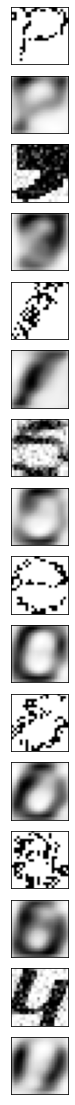

In [307]:
def plotComparisons(model):

    plt.figure( figsize=(20, 20) )

    testing_loader = torch.utils.data.DataLoader( X_noisy, batch_size=8, shuffle=True, num_workers=0 )

    for i, image in enumerate(testing_loader):
        if i >= 8:
            break
        images = image[0]

        with torch.no_grad():
            denoised = model(images.to(torch.float32).to(device))
            for j in range( len(images) ):

                # Original
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].cpu().reshape(20,20), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                # Denoised
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(denoised[j].cpu().reshape(20,20), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

plotComparisons(denoise_network)
torch.cuda.empty_cache()